In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('tes'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



tes\train\AD\AD (1).jpg
tes\train\AD\AD (10).jpg
tes\train\AD\AD (100).jpg
tes\train\AD\AD (101).jpg
tes\train\AD\AD (102).jpg
tes\train\AD\AD (103).jpg
tes\train\AD\AD (104).jpg
tes\train\AD\AD (105).jpg
tes\train\AD\AD (106).jpg
tes\train\AD\AD (107).jpg
tes\train\AD\AD (108).jpg
tes\train\AD\AD (109).jpg
tes\train\AD\AD (11).jpg
tes\train\AD\AD (110).jpg
tes\train\AD\AD (111).jpg
tes\train\AD\AD (112).jpg
tes\train\AD\AD (113).jpg
tes\train\AD\AD (114).jpg
tes\train\AD\AD (115).jpg
tes\train\AD\AD (116).jpg
tes\train\AD\AD (117).jpg
tes\train\AD\AD (118).jpg
tes\train\AD\AD (119).jpg
tes\train\AD\AD (12).jpg
tes\train\AD\AD (120).jpg
tes\train\AD\AD (121).jpg
tes\train\AD\AD (122).jpg
tes\train\AD\AD (123).jpg
tes\train\AD\AD (124).jpg
tes\train\AD\AD (125).jpg
tes\train\AD\AD (126).jpg
tes\train\AD\AD (127).jpg
tes\train\AD\AD (128).jpg
tes\train\AD\AD (129).jpg
tes\train\AD\AD (13).jpg
tes\train\AD\AD (130).jpg
tes\train\AD\AD (131).jpg
tes\train\AD\AD (132).jpg
tes\train\AD\AD (

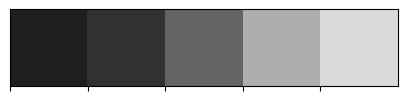

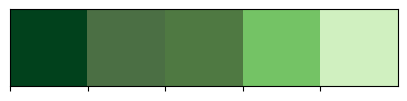

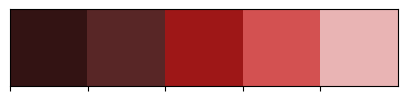

In [2]:
#Palette Warna untuk membuat grafik dan tabel confusion matrix
colors_dark = ['#1F1F1F', '#313131', '#636363', '#AEAEAE', '#DADADA']
colors_red = ['#331313', '#582626', '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
#Melabeli setiap kelas
labels = ['AD', 'CN', 'MCI']

In [4]:
#Resize gambar dan mengkonversi data kedalam bentuk array
X_train = []
y_train = []
image_size = 192
for i in labels:
    folderPath = os.path.join('tes', 'train', i)
    for j in tqdm (os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('tes', 'val', i)
    for j in tqdm (os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 200/200 [00:00<00:00, 1023.89it/s]


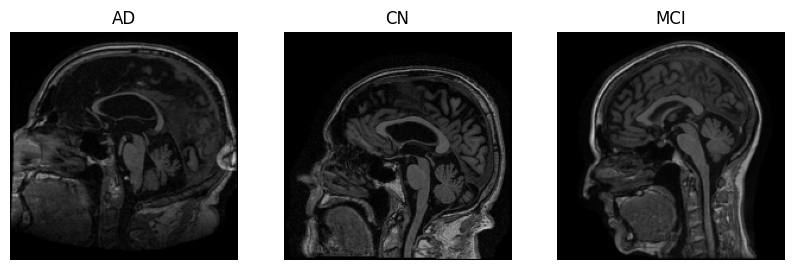

In [5]:
#Proses mengambil sampel, 1 sampel setiap kelas
k=0
fig, ax = plt.subplots(1,3,figsize=(10,10))
fig.text(s='', size=18, fontweight='bold', fontname='DejaVu Sans', color=colors_dark[1], y=0.62, x=0.4, alpha=0.8)
for i in labels:
    j=0
    while True:
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
#Mengacak urutan data
X_train, y_train = shuffle(X_train, y_train, random_state=101)

In [7]:
#Mengetahui bentuk data
X_train.shape

(3000, 192, 192, 3)

In [8]:
#Mengambil sampel dengan teknik random sampling data untuk data uji
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2400, 192, 192, 3), (600, 192, 192, 3), (2400,), (600,))

In [9]:
# Mengonversi label menjadi numerik menggunakan LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Perbaiki jumlah kelas yang diharapkan
num_classes = len(label_encoder.classes_)

# One Hot Encoding untuk y_train
y_train = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

# One Hot Encoding untuk y_test
y_test = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)

In [10]:
#Proses inisialisasi model ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

In [11]:
# Membuat top layers baru di atas basis model
model = base_model.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)
model = tf.keras.models.Model(inputs=base_model.input, outputs=model)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 198, 198, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 96, 96, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 96, 96, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 48, 48, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 48, 48, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 48, 48, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 24, 24, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 24, 24, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 24, 24, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 12, 12, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 12, 12, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 12, 12, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 12, 12, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 12, 12, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 12, 12, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 12, 12, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 12, 12, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 12, 12, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 12, 12, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 6, 6, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 6, 6, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 6, 6, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 6, 6, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [12]:
#Proses Compile
model.compile(loss='categorical_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

In [13]:
#Mengatur Callback unutk pemantauan dan pengendalian pelatihan model
tensorboard = TensorBoard(log_dir='logs')
reduce_lr=ReduceLROnPlateau(monitor="val_accuracy", factor=0.3, patience=2, min_delta=0.001, mode="auto", verbose=1)

In [14]:
#Proses pelatihan akan diinisiasi
history = model.fit(X_train,y_train,validation_split=0.2,
                    epochs = 20,
                    verbose=1,
                    batch_size=32,
                    callbacks=[tensorboard,reduce_lr])

#Proses menyimpan model
#model.save("alzheimer_model.h5")

Epoch 1/20


60/60 [==============================] - 131s 2s/step - loss: 1.3809 - accuracy: 0.4031 - val_loss: 64.3890 - val_accuracy: 0.3250 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 118s 2s/step - loss: 1.0283 - accuracy: 0.5318 - val_loss: 1.3783 - val_accuracy: 0.4229 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 116s 2s/step - loss: 0.6282 - accuracy: 0.7406 - val_loss: 2.8489 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 117s 2s/step - loss: 0.4898 - accuracy: 0.8125 - val_loss: 1.8476 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 118s 2s/step - loss: 0.2475 - accuracy: 0.9094 - val_loss: 2.5265 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 115s 2s/step - loss: 0.1866 - accuracy: 0.9307 - val_loss: 6.1047 - val_accuracy: 0.3271 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 112s 2s/step - loss: 

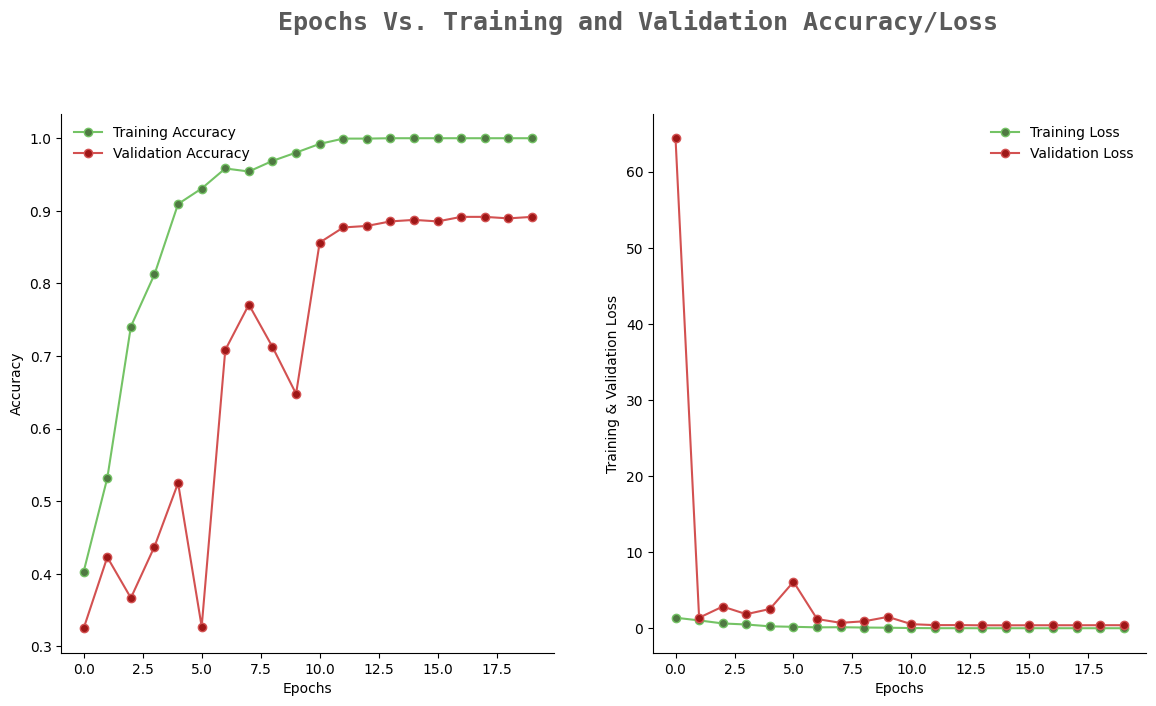

In [15]:
#Proses memvisualisasikan Learning Curve
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text (s='Epochs Vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold', fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[2], color=colors_green[3], label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[2], color=colors_red[3], label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3], label = 'Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3], label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

19/19 [==============================] - 10s 511ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       197
           1       0.88      0.88      0.88       210
           2       0.82      0.83      0.83       193

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600

Test Accuracy: 86.3333 %




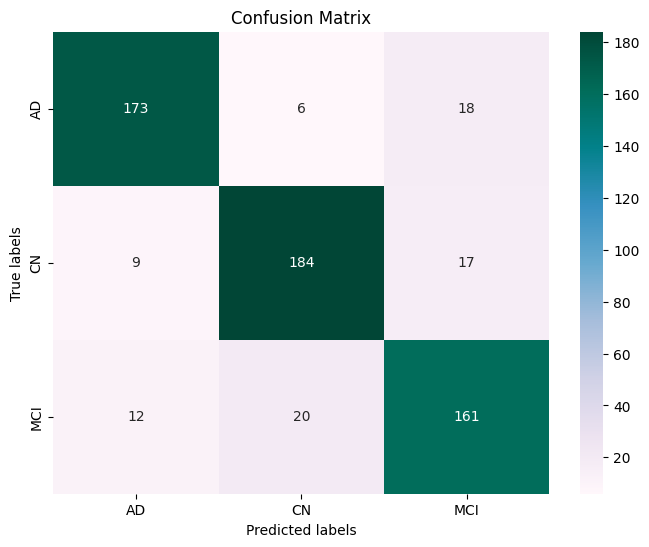

In [16]:
#evaluasi model test
predict_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)


# Menghitung confusion matrix
conf_matrix = confusion_matrix(ytest_, predict_test)
test_accu = np.sum(ytest_ == predict_test) / len(ytest_) * 100

#menampilkan hasil akurasi dan classification report
print(classification_report(ytest_, predict_test))
print(f"Test Accuracy: {round(test_accu, 4)} %\n\n")


# Membuat plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='PuBuGn', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

75/75 [==============================] - 40s 534ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       803
           1       0.98      0.98      0.98       790
           2       0.97      0.98      0.97       807

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400

Train Accuracy: 97.8333 %




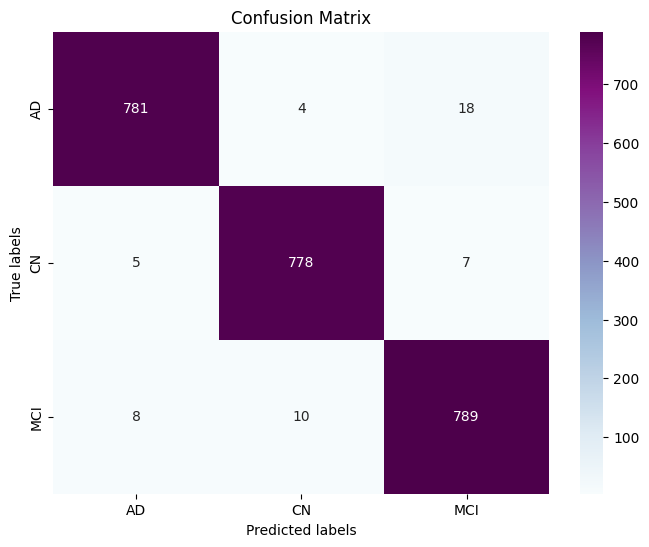

In [17]:
#evaluasi model train
predict_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

# Menghitung confusion matrix
conf_matrix = confusion_matrix(ytrain_, predict_train)
train_accu = np.sum(ytrain_ == predict_train) / len(ytrain_) * 100

#menampilkan hasil akurasi dan classification report
print(classification_report(ytrain_, predict_train))
print(f"Train Accuracy: {round(train_accu, 4)} %\n\n")

# Membuat plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='BuPu', cbar=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
def plot_true_classified(alzheimer):
    # Find the index of the class label in the 'labels' list
    alzheimer_index = labels.index(alzheimer)
    
    true_indices = np.where((ytest_ == predict_test) & (ytest_==alzheimer_index))[0]
    print(f"Total {len(true_indices)} true labels out of {len(np.where(ytest_==alzheimer_index)[0])} for Alzheimer's disease class")

    # Limit to only 5 images
    true_indices = true_indices[:5]
    cols = 5
    rows = 1
    fig = plt.figure(1, (20, rows * 2))

    for i, idx in enumerate(true_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        true_label = labels[ytest_[idx]]  # Get the correct label from ytest_
        pred = labels[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(sample_img[0,:,:,:], cmap='gray') # Displaying image, assuming it's grayscale
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"True:{true_label}, Predicted:{pred}") 


Total 173 true labels out of 197 for Alzheimer's disease class
1/1 [==============================] - 0s 60ms/step


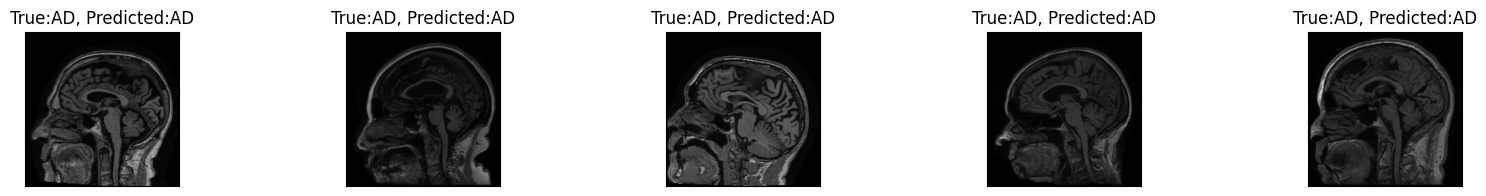

In [28]:
plot_true_classified('AD')

Total 184 true labels out of 210 for Alzheimer's disease class
1/1 [==============================] - 0s 57ms/step


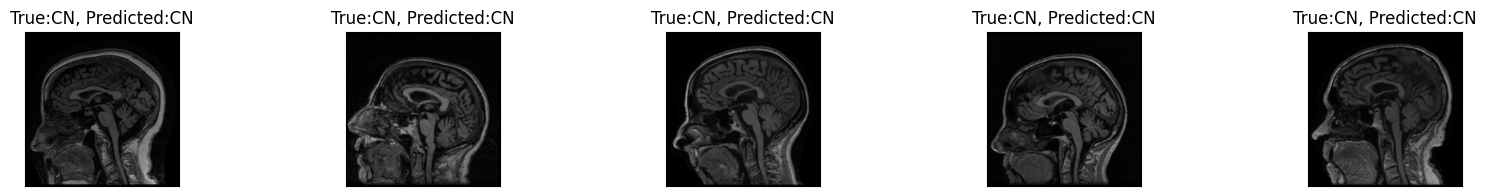

In [29]:
plot_true_classified('CN')

Total 161 true labels out of 193 for Alzheimer's disease class
1/1 [==============================] - 0s 61ms/step


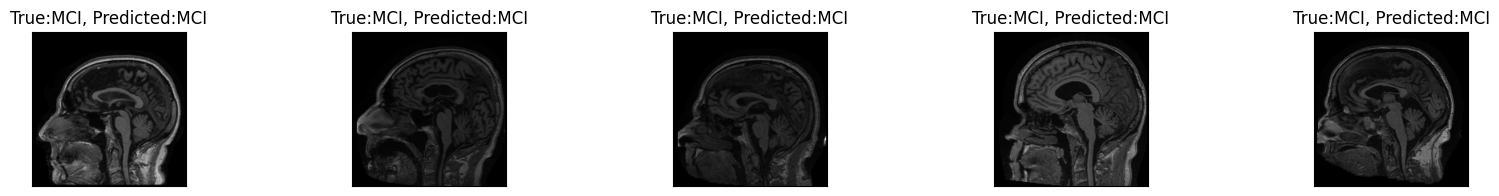

In [30]:
plot_true_classified('MCI')

In [33]:
def plot_miss_classified(alzheimer):
    # Find the index of the class label in the 'labels' list
    alzheimer_index = labels.index(alzheimer)
    
    miss_indices = np.where((ytest_ != predict_test) & (ytest_==alzheimer_index))[0]
    print(f"Total {len(miss_indices)} miss labels out of {len(np.where(ytest_==alzheimer_index)[0])} for Alzheimer's disease class")

    # Limit to only 5 images
    miss_indices = miss_indices[:5]
    cols = 5
    rows = 1
    fig = plt.figure(1, (20, rows * 2))

    for i, idx in enumerate(miss_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        true_label = labels[ytest_[idx]]  # Get the correct label from ytest_
        pred = labels[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(sample_img[0,:,:,:], cmap='gray') # Displaying image, assuming it's grayscale
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"True:{true_label}, Predicted:{pred}") 

Total 24 miss labels out of 197 for Alzheimer's disease class
1/1 [==============================] - 0s 58ms/step


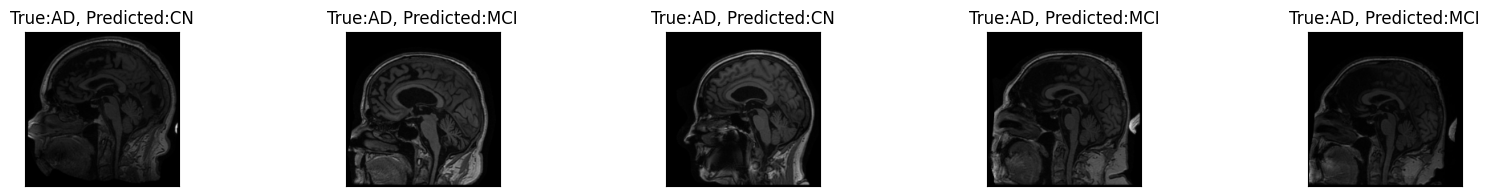

In [34]:
plot_miss_classified('AD')

Total 26 miss labels out of 210 for Alzheimer's disease class
1/1 [==============================] - 0s 61ms/step


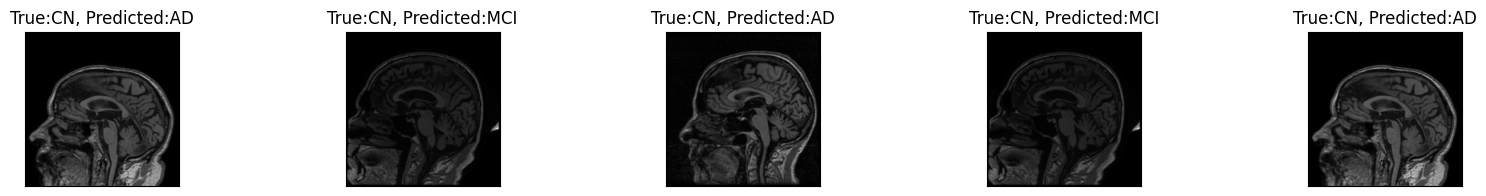

In [35]:
plot_miss_classified('CN')

Total 32 miss labels out of 193 for Alzheimer's disease class
1/1 [==============================] - 0s 58ms/step


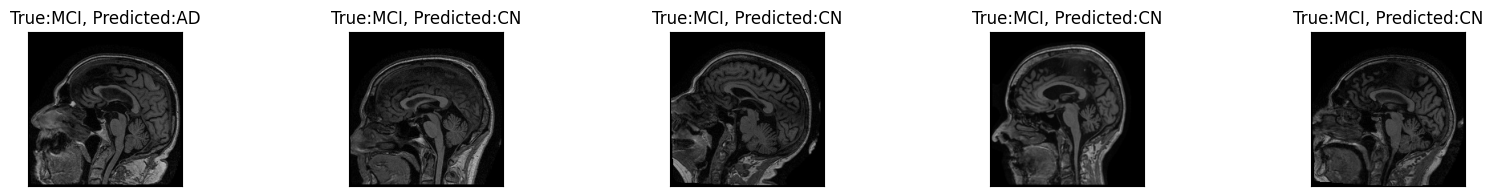

In [36]:
plot_miss_classified('MCI')